# Estimate time series parameters using pseudo batch transformed data
This tutorial will walk through how to estimate a series for the rates and yields from a fed-batch fermentation. This can be useful to detect changes in the phenotype during the fed-batch process. We will work with simulated data, thus the true parameters will be known.

## Initialise session and loading data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import numpy as np
import os

from pseudobatch import pseudobatch_transform_pandas, convert_volumetric_rates_from_pseudo_to_real
from pseudobatch.datasets import load_product_inhibited_fedbatch

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
fedbatch_df_measurement = load_product_inhibited_fedbatch(sampling_points_only=True)

# for visualization purposes we will also load the full dataset
fedbatch_df = load_product_inhibited_fedbatch(sampling_points_only=False)

First, let's quickly inspect the dataframe

In [3]:
(fedbatch_df_measurement
    .filter(['timestamp', 'sample_volume', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum'])
    .head()
)

timestamp  sample_volume  c_Biomass  c_Glucose  c_Product     v_Volume   
0  10.000000          100.0   1.315046   0.117208   0.676000  1015.906036  \
1  14.545455          100.0   2.026109   0.171224   1.265827   928.960902   
2  19.090909          100.0   3.083525   0.296168   2.143140   847.314262   
3  23.636364          100.0   4.568350   0.651151   3.375809   772.816654   
4  28.181818          100.0   6.410392   1.735493   4.907704   707.795685   

   v_Feed_accum  
0     15.906036  
1     28.960902  
2     47.314262  
3     72.816654  
4    107.795685

This dataframe is structured exactly similar to the one use in the previous tutorial, though the data is different. We can go straight to the pseudo batch transformation.

In [16]:
glucose_in_feed = fedbatch_df_measurement["s_f"].iloc[0] # The glucose concentration in the feed is constant and store in a row in the dataframe.

fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df_measurement,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product", "c_CO2"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=[0, glucose_in_feed, 0, 0], # The biomass, product, CO2 concentrations in the feed are all 0.
)

Now that we have transformed the data we can estimate parameters.

## Estimate the growth rate

We want to obtain estimates the growth rate as a function of time, i.e. to estimate $\mu(t)$. First, we will look at the mass balance for biomass. Because we can treat the pseudo batch transformed data as a batch process, we can do the mass balance on pseudo concentration basis instead of mass basis. Assuming that the death rate is 0, the mass balance for the biomass is as follows:
$$
\frac{dC^{\star}_{Biomass}(t)}{dt} = \mu(t) * C^{\star}_{Biomass}(t) 
$$
Where $X(t)$ is the biomass in grams, and $\mu$ is the specific growth rate, The goal is to find $\mu(t)$, therefore we can isolate $\mu(t)$ to get 
$$
\mu(t) = \frac{dC^{\star}_{Biomass}(t)}{dt} * C^{\star}_{Biomass}(t)^{-1}
$$ 

Thus, to calculate the time dependent growth rate, we will need the time derivative of the pseudo biomass concentration ($\frac{dC^{\star}_{Biomass}(t)}{dt}$) and the pseudo biomass concentration ($C^{\star}_{Biomass}(t)$). We already have the pseudo biomass concentration measurements, but we need to estimate $\frac{dC^{\star}_{Biomass}(t)}{dt}$. There are many methods that are capable of estimating the derivative of an underlying function (the true growth curve). Typically, these methods assume that the underlying function is continuous. This is not the case for the biomass time series, because samples where drawn from this cultivation. Fortunately, the pseudo batch transformation transform the measurements into a space where underlying growth curve is continuous and therefore the pseudo batch transformation enables the use of many methods to estimate rates as a function of time.

Here, we will show how to use finite differences to estimate the growth rate at each measurement time point. First, we will define a function that estimate the time derivative using the finite difference method in the `np.gradient()` function.


In [17]:
def finite_difference_derivative(df: pd.DataFrame, x_colname: str, y_colname: str, log_transform_y: bool = False)->np.ndarray:
    x = df[x_colname].to_numpy()
    if log_transform_y:
        y = df[y_colname].transform(np.log).to_numpy()
    else:
        y = df[y_colname].to_numpy()
    return np.gradient(y, x)

Now, we can estimate $\mu(t)$ as describe in the equation above.

In [18]:
mu_hat = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Biomass_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo

We can plot $\hat\mu(t)$ as a function of time to inspect is the growth rate was constant over course of the cultivation.

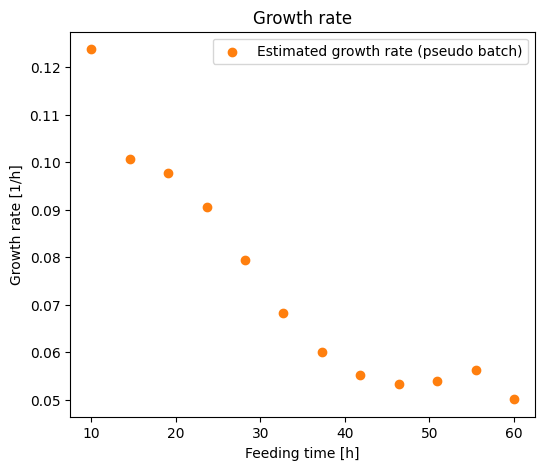

In [19]:
growth_rate_fig, growth_rate_ax = plt.subplots(figsize=(6, 5))
growth_rate_ax.scatter(fedbatch_df_measurement.timestamp, mu_hat, label="Estimated growth rate (pseudo batch)", color = "C1")
growth_rate_ax.set_title("Growth rate")
growth_rate_ax.set_xlabel("Feeding time [h]")
growth_rate_ax.set_ylabel("Growth rate [1/h]")
growth_rate_ax.legend()

From this specific growth rate time series we can see that the rate decreases during the fed-batch process. This hints that something may build up during the process and inhibiting the growth.
Because this data is simulated we know the true growth rate and we can compare this to the estimated growth rates.

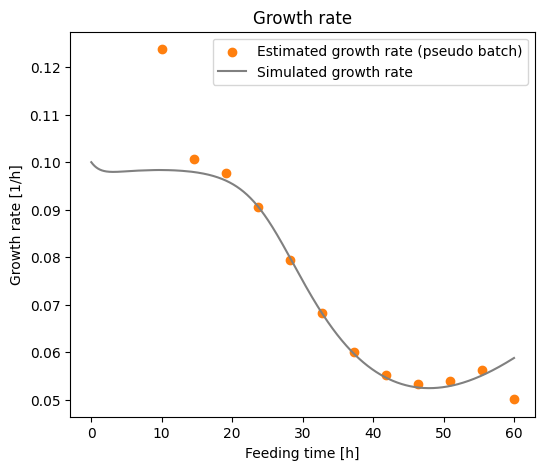

In [20]:
growth_rate_ax.plot(fedbatch_df.timestamp, fedbatch_df['mu_true'], label="Simulated growth rate", color = 'grey')[0]
growth_rate_ax.legend()
growth_rate_fig

We see that the estimate is in general close to true growth rate. but close to the boundaries the estimate gets worse. This is because the `np.gradient()` function use a rolling window af 5 data points (centered) to estimate the derivative, but at the boundaries there are not enough data points to fill the window. Therefore the quality of the estimate decreases. Remember that this is simulated data, and therefore we have the accurate measurements. That is not the case in the real world, here the measurements will be noisy, which will be reflected in the accuracy of the growth rate estimates.

## Estimate specific consumption or production rates
Similarly to what we did for growth rate we can setup mass balances for the individual species again on pseudo concentration basis.
$$
\frac{dC^{\star}_{species}(t)}{dt} = r_{species} * C^{\star}_{Biomass}(t)
$$
Where $C^{\star}_{species}(t)$ pseudo concentration of $species$, $r_{species}$ is the specific rate of the $species$, and $C^{\star}_{Biomass}(t)$ pseudo biomass concentration. The goal is to find $r_{species}(t)$, therefore we can isolate $r_{species}(t)$ to get 
$$
r_{species} = \frac{dC^{\star}_{species}(t)}{dt} * C^{\star}_{Biomass}(t)^{-1}
$$ 

Similarly to the growth rate, we can estimate $\frac{dC^{\star}_{species}(t)}{dt}$ as the first order derivative of the time evolution of the species mass. Again using finite difference method we can estimate the rate as follows.

In [25]:
r_glucose_uptake = -1*finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Glucose_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo
r_product_production = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Product_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo
r_co2_production = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_CO2_pseudo", log_transform_y=False) / fedbatch_df_measurement.c_Biomass_pseudo

We can plot the estimated rate along with the true rates.

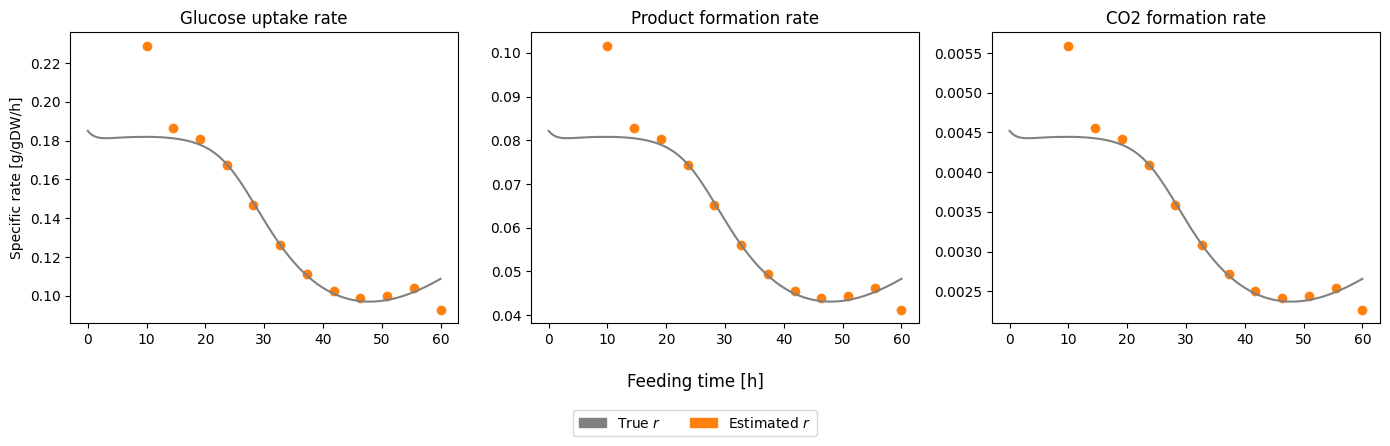

In [24]:
# Plot the results
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(14, 4))
axes[0].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxs'], label="Simulated glucose uptake rate", color="grey")
axes[0].scatter(fedbatch_df_measurement["timestamp"], r_glucose_uptake, label="Estimated glucose uptake rate (pseudo batch)", color = "C1")
axes[0].set_title("Glucose uptake rate")
axes[1].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxp'], label="Simulated product formation rate", color="grey")
axes[1].scatter(fedbatch_df_measurement["timestamp"], r_product_production, label="Estimated product formation rate (pseudo batch)", color = "C1")
axes[1].set_title("Product formation rate")
axes[2].plot(fedbatch_df["timestamp"], fedbatch_df["mu_true"]*fedbatch_df['Yxco2'], label="Simulated CO2 formation rate", color="grey")
axes[2].scatter(fedbatch_df_measurement["timestamp"], r_co2_production, label="Estimated CO2 formation rate (pseudo batch)", color = "C1")
axes[2].set_title("CO2 formation rate")

# setup legend
true_patch = mpatches.Patch(color='grey', label=r'True $r$')
pseudo_patch = mpatches.Patch(color='C1', label=r'Estimated $r$')

fig.legend(
    handles=[true_patch, pseudo_patch],
    loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.12)
)

fig.supxlabel("Feeding time [h]")
axes[0].set_ylabel("Specific rate [g/gDW/h]")
fig.tight_layout()

Because this is simulated data the plot these plot are very similar only scaled differently, but it shows how estimate the rates as function of time based on pseudo batch transformed data.

## Estimate volumetric rates 

Sometimes one is interested in the volumetric rates. These can also be calculated from the pseudo batch transformed data, but it requires a bit extra care. 


Recall that in a batch process there is no volume change and therefore all changes in concentrations are due to cellular behavior (if we ignore phenomena as evaporation and gas stripping). Thus the volumetric rates can be calculated from the pseudo batch transformed data by estimating the differential quotient and the concentration time series data. 

$$
q^{\star}_{species} = \frac{dC_{species}^{\star}}{dt}
$$

Though this volumetric rate describes the rate of change in the pseudo concentration, which is not the same as the rate of change of the real concentration. We can convert it to real concentration using the function `convert_volumetric_rates_from_pseudo_to_real()`. 

In the following we will use the finite difference method to estimate $\frac{dC_{species}^{\star}}{dt}$ and them convert it into real concentrations to obtain as estimate of the volumetric rates.

In [27]:
# Estimate finite difference derivatives
fedbatch_df_measurement['q_star_biomass_production'] = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Biomass_pseudo", log_transform_y=False)
fedbatch_df_measurement['q_star_glucose_uptake'] = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Glucose_pseudo", log_transform_y=False) 
fedbatch_df_measurement['q_star_product_production'] = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Product_pseudo", log_transform_y=False)
fedbatch_df_measurement['q_star_co2_production'] = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_CO2_pseudo", log_transform_y=False)

In [28]:
# convert to real volumetric rates
fedbatch_df_measurement['q_biomass'] = convert_volumetric_rates_from_pseudo_to_real(fedbatch_df_measurement.q_star_biomass_production, reactor_volume=fedbatch_df_measurement.v_Volume, sample_volume=fedbatch_df_measurement.sample_volume)
fedbatch_df_measurement['q_glucose'] = convert_volumetric_rates_from_pseudo_to_real(fedbatch_df_measurement.q_star_glucose_uptake, reactor_volume=fedbatch_df_measurement.v_Volume, sample_volume=fedbatch_df_measurement.sample_volume)
fedbatch_df_measurement['q_product'] = convert_volumetric_rates_from_pseudo_to_real(fedbatch_df_measurement.q_star_product_production, reactor_volume=fedbatch_df_measurement.v_Volume, sample_volume=fedbatch_df_measurement.sample_volume)
fedbatch_df_measurement['q_co2'] = convert_volumetric_rates_from_pseudo_to_real(fedbatch_df_measurement.q_star_co2_production, reactor_volume=fedbatch_df_measurement.v_Volume, sample_volume=fedbatch_df_measurement.sample_volume)

For comparison we will now calculate the true volumetric rates

In [29]:
# true volumetric rates
true_volumetric_rates = fedbatch_df.filter(['timestamp']).copy()

true_volumetric_rates['q_biomass'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass
true_volumetric_rates['q_glucose'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * -1*fedbatch_df.Yxs
true_volumetric_rates['q_product'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * fedbatch_df.Yxp
true_volumetric_rates['q_co2'] = fedbatch_df.mu_true * fedbatch_df.c_Biomass * fedbatch_df.Yxco2

Finally, we can plot true and estimate volumetric rates

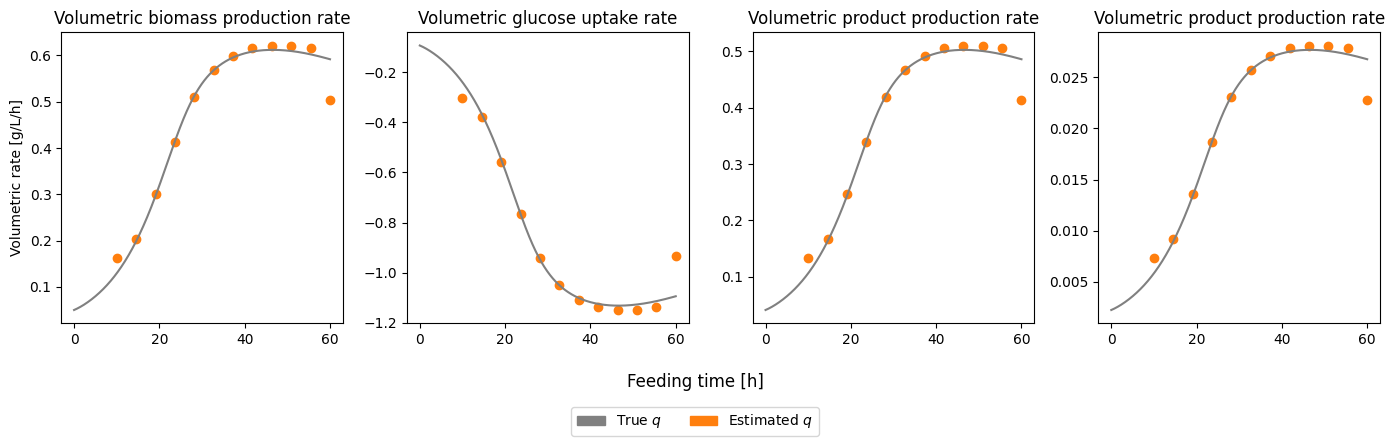

In [30]:
# Plot the results

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(14, 4))
axes[0].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_biomass"], label="Simulated glucose uptake rate", color="grey")
axes[0].scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement['q_biomass'], color = "C1")
axes[0].set_title("Volumetric biomass production rate")

axes[1].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_glucose"], color="grey")
axes[1].scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement['q_glucose'], color = "C1")
axes[1].set_title("Volumetric glucose uptake rate")

axes[2].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_product"], color="grey")
axes[2].scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement['q_product'], color = "C1")
axes[2].set_title("Volumetric product production rate")

axes[3].plot(true_volumetric_rates["timestamp"], true_volumetric_rates["q_co2"], color="grey")
axes[3].scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement['q_co2'], color = "C1")
axes[3].set_title("Volumetric product production rate")

# setup legend
true_patch = mpatches.Patch(color='grey', label=r'True $q$')
pseudo_patch = mpatches.Patch(color='C1', label=r'Estimated $q$')

fig.legend(
    handles=[true_patch, pseudo_patch],
    loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.12)
)
fig.supxlabel("Feeding time [h]")
axes[0].set_ylabel("Volumetric rate [g/L/h]")
fig.tight_layout()

We see that the estimate the volumetric rates are very good, but again similar to the specific rates it is difficult to get good estimates close the boundaries of the time series.